In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading datasets

In [65]:
from pathlib import Path

# Define data directory
DATA_DIR = Path("../../data/data_splits")

# Load labeled training data
print("\n[1/4] Loading labeled training data...")
X_train_labeled = pd.read_csv(DATA_DIR / "X_train_labeled.csv")
y_train_labeled = pd.read_csv(DATA_DIR / "y_train_labeled.csv")
print(f"Labeled samples: {len(X_train_labeled):,} | Features: {X_train_labeled.shape[1]}")

# Load unlabeled training data
print("\n[2/4] Loading unlabeled training data...")
X_train_unlabeled = pd.read_csv(DATA_DIR / "X_train_unlabeled.csv")
y_train_unlabeled = pd.read_csv(DATA_DIR / "y_train_unlabeled.csv")
print(f"Unlabeled samples: {len(X_train_unlabeled):,} | Features: {X_train_unlabeled.shape[1]}")


# Combine labeled and unlabeled data
print("\n[3/4] Combining training datasets...")
# Reset indices to avoid conflicts
X_train_labeled = X_train_labeled.reset_index(drop=True)
X_train_unlabeled = X_train_unlabeled.reset_index(drop=True)
y_train_labeled = y_train_labeled.reset_index(drop=True)

# Combine features
X_train = pd.concat([X_train_labeled, X_train_unlabeled], axis=0, ignore_index=True)

# Create placeholder labels for unlabeled data (NaN)
y_unlabeled = pd.DataFrame(
    np.nan, 
    index=range(len(X_train_unlabeled)), 
    columns=y_train_labeled.columns
)

# Combine labeled + unlabeled targets
y_train = pd.concat([y_train_labeled, y_unlabeled], axis=0, ignore_index=True)

labeled_ratio = len(X_train_labeled) / len(X_train) * 100
print(f"Total training samples: {len(X_train):,}")
print(f"Labeled: {len(X_train_labeled):,} ({labeled_ratio:.1f}%)")
print(f"Unlabeled: {len(X_train_unlabeled):,} ({100-labeled_ratio:.1f}%)")

# Load validation and test sets
print("\n[4/4] Loading validation and test sets...")
X_val = pd.read_csv(DATA_DIR / "X_val.csv")
y_val = pd.read_csv(DATA_DIR / "y_val.csv")
X_test = pd.read_csv(DATA_DIR / "X_test.csv")
y_test = pd.read_csv(DATA_DIR / "y_test.csv")

print(f"Validation: {len(X_val):,} samples")
print(f"Test: {len(X_test):,} samples")


[1/4] Loading labeled training data...
Labeled samples: 93 | Features: 47

[2/4] Loading unlabeled training data...
Unlabeled samples: 1,518 | Features: 47

[3/4] Combining training datasets...
Total training samples: 1,611
Labeled: 93 (5.8%)
Unlabeled: 1,518 (94.2%)

[4/4] Loading validation and test sets...
Validation: 20 samples
Test: 21 samples


In [66]:
# Summary
print("\n" + "=" * 140)
print("DATASET SUMMARY")
print("=" * 140)
print(f"Training:   {len(X_train):,} samples x {X_train.shape[1]} features")
print(f"Validation: {len(X_val):,} samples x {X_val.shape[1]} features")
print(f"Test:       {len(X_test):,} samples x {X_test.shape[1]} features")
print(f"Target columns: {list(y_train_labeled.columns)}")
print(f"Missing labels in y_train: {y_train.isna().any(axis=1).sum():,}")
print("=" * 140)


DATASET SUMMARY
Training:   1,611 samples x 47 features
Validation: 20 samples x 47 features
Test:       21 samples x 47 features
Target columns: ['yield_strength_MPa', 'uts_MPa', 'elongation_pct', 'reduction_area_pct', 'charpy_temp_C', 'charpy_toughness_J']
Missing labels in y_train: 1,518


### Handling missing values

#### Dropping very spare columns

In [67]:
# Calculate missing percentage for each column in X_train
missing_pct = (X_train.isnull().sum() / len(X_train)) * 100

# Find columns with >= 70% missing values
drop_thresh = 70
high_missing_cols = missing_pct[missing_pct >= drop_thresh].sort_values(ascending=False)

print(f"\nColumns with >= {drop_thresh}% missing values:\n\n{high_missing_cols}")


Columns with >= 70% missing values:

tungsten_wt_pct             96.089385
boron_ppm                   94.972067
martensite_pct              94.475481
ferrite_carbide_pct         94.475481
ferrite_second_phase_pct    94.413408
acicular_ferrite_pct        94.413408
primary_ferrite_pct         94.040968
cobalt_wt_pct               93.296089
arsenic_ppm                 85.971446
antimony_ppm                84.295469
tin_ppm                     82.184978
niobium_ppm                 72.811918
dtype: float64


In [68]:
cols_to_drop = high_missing_cols.index.tolist()

# Drop from training set
X_train_clean = X_train.drop(columns=cols_to_drop)

# Drop from validation set
X_val_clean = X_val.drop(columns=cols_to_drop)

# Drop from test set
X_test_clean = X_test.drop(columns=cols_to_drop)

print(f"X_train_clean: {X_train_clean.shape}")
print(f"X_val_clean:   {X_val_clean.shape}")
print(f"X_test_clean:  {X_test_clean.shape}")


X_train_clean: (1611, 35)
X_val_clean:   (20, 35)
X_test_clean:  (21, 35)


#### Missing values imputation

In [69]:
#X_train_clean.info()

##### 1. Composition columns

In [70]:
# Replacing missing sulfur and phosphorus with mean (as done in the thesis)
for col in ["sulfur_wt_pct", "phosphorus_wt_pct"]:
    X_train_clean[col].fillna(X_train_clean[col].mean(), inplace=True)
    X_val_clean[col].fillna(X_train_clean[col].mean(), inplace=True)   # use train mean
    X_test_clean[col].fillna(X_train_clean[col].mean(), inplace=True)  # use train mean

# Replacing other alloying elements with 0 (not deliberately added)
elements_to_zero = [
    'carbon_wt_pct', 'silicon_wt_pct', 'manganese_wt_pct', 'nickel_wt_pct', 'chromium_wt_pct',
    'molybdenum_wt_pct', 'vanadium_wt_pct', 'copper_wt_pct', 'oxygen_ppm',
    'titanium_ppm', 'nitrogen_ppm', 'aluminium_ppm'
]

for col in elements_to_zero:
    X_train_clean[col].fillna(0, inplace=True)
    X_val_clean[col].fillna(0, inplace=True)
    X_test_clean[col].fillna(0, inplace=True)


##### 2. Other columns

In [71]:
#X_train_clean.info()

In [72]:
missing_cols = X_train_clean.select_dtypes(include="number").columns[X_train_clean.isnull().any()].tolist()

print("Numeric columns with missing values:", missing_cols)


Numeric columns with missing values: ['current_A', 'voltage_V', 'interpass_temp_C', 'pwht_temp_C', 'pwht_time_h']


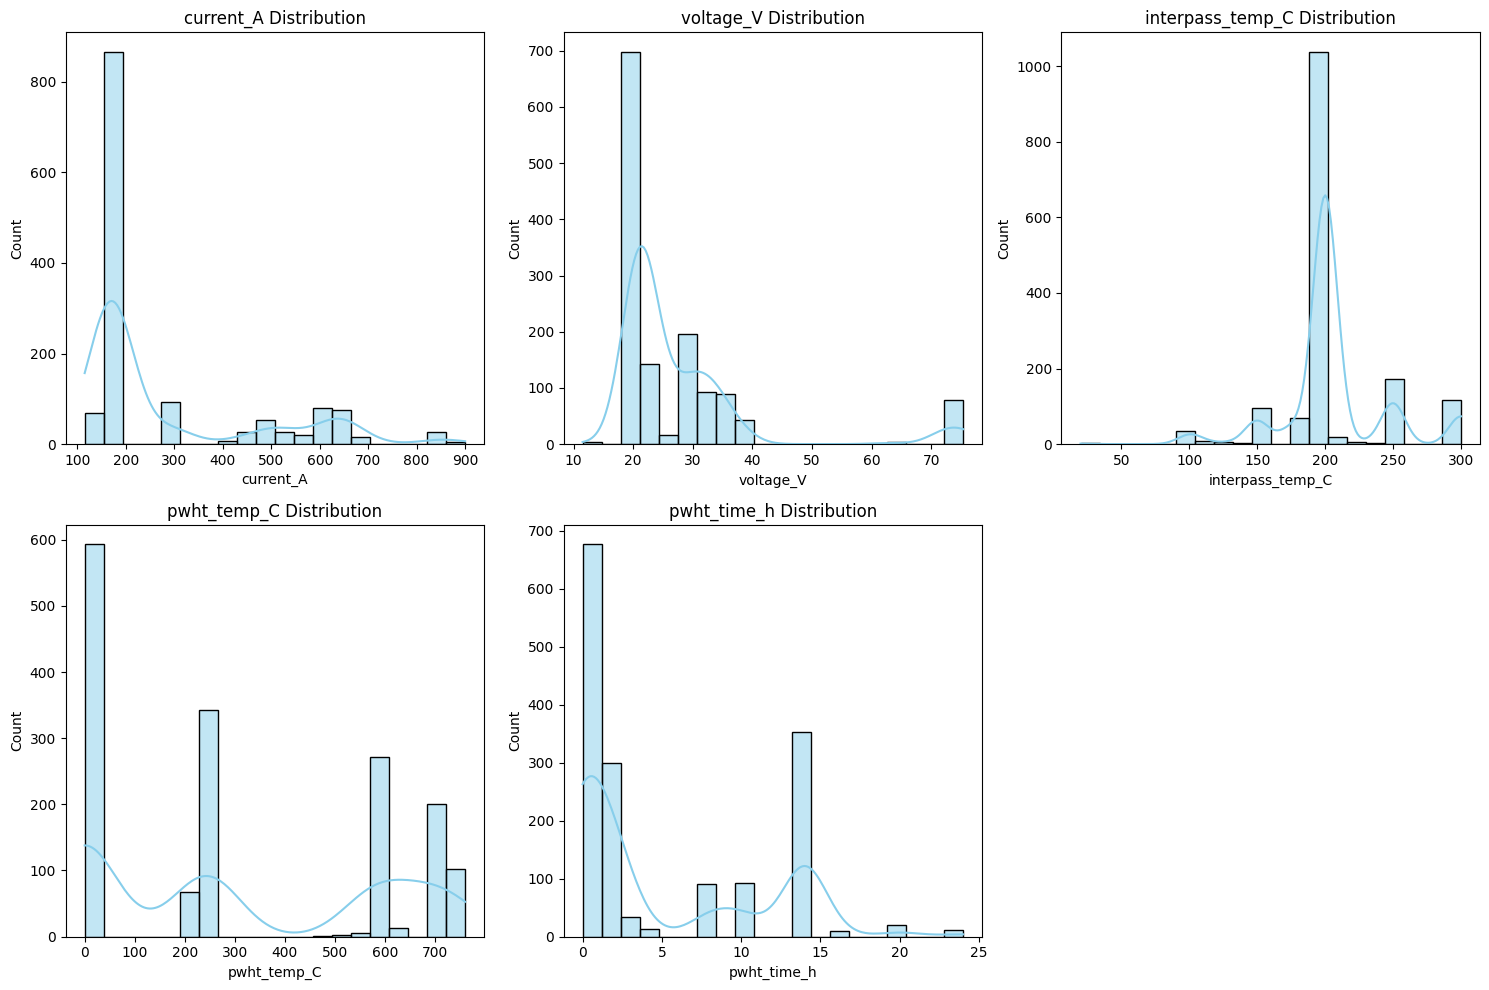

In [73]:
# Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(missing_cols, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 cols
    sns.histplot(X_train_clean[col], kde=True, bins=20, color='skyblue')
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

**Applying most frequent imputation**

In [74]:
from sklearn.impute import SimpleImputer

# Create imputer with 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')  

# Fit on training data only
imputer.fit(X_train_clean[missing_cols])

# Transform all datasets
print("\n[Step 1/3] Transforming training data...")
X_train_clean[missing_cols] = imputer.transform(X_train_clean[missing_cols])
print(f"Training set transformed: {X_train_clean.shape}")

print("\n[Step 2/3] Transforming validation data...")
X_val_clean[missing_cols] = imputer.transform(X_val_clean[missing_cols])
print(f"Validation set transformed: {X_val_clean.shape}")

print("\n[Step 3/3] Transforming test data...")
X_test_clean[missing_cols] = imputer.transform(X_test_clean[missing_cols])
print(f"Test set transformed: {X_test_clean.shape}")



[Step 1/3] Transforming training data...
Training set transformed: (1611, 35)

[Step 2/3] Transforming validation data...
Validation set transformed: (20, 35)

[Step 3/3] Transforming test data...
Test set transformed: (21, 35)


In [75]:
# Show most frequent values used
print("\nMost frequent values used for imputation:")
print("-" * 41)
for i, col in enumerate(missing_cols):
    most_frequent_value = imputer.statistics_[i]
    print(f"{col:20s}: {most_frequent_value:.2f}")


Most frequent values used for imputation:
-----------------------------------------
current_A           : 170.00
voltage_V           : 21.00
interpass_temp_C    : 200.00
pwht_temp_C         : 0.00
pwht_time_h         : 0.00


In [76]:
X_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611 entries, 0 to 1610
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   carbon_wt_pct         1611 non-null   float64
 1   silicon_wt_pct        1611 non-null   float64
 2   manganese_wt_pct      1611 non-null   float64
 3   sulfur_wt_pct         1611 non-null   float64
 4   phosphorus_wt_pct     1611 non-null   float64
 5   nickel_wt_pct         1611 non-null   float64
 6   chromium_wt_pct       1611 non-null   float64
 7   molybdenum_wt_pct     1611 non-null   float64
 8   vanadium_wt_pct       1611 non-null   float64
 9   copper_wt_pct         1611 non-null   float64
 10  oxygen_ppm            1611 non-null   float64
 11  titanium_ppm          1611 non-null   float64
 12  nitrogen_ppm          1611 non-null   float64
 13  aluminium_ppm         1611 non-null   float64
 14  current_A             1611 non-null   float64
 15  voltage_V            

### Data distribution

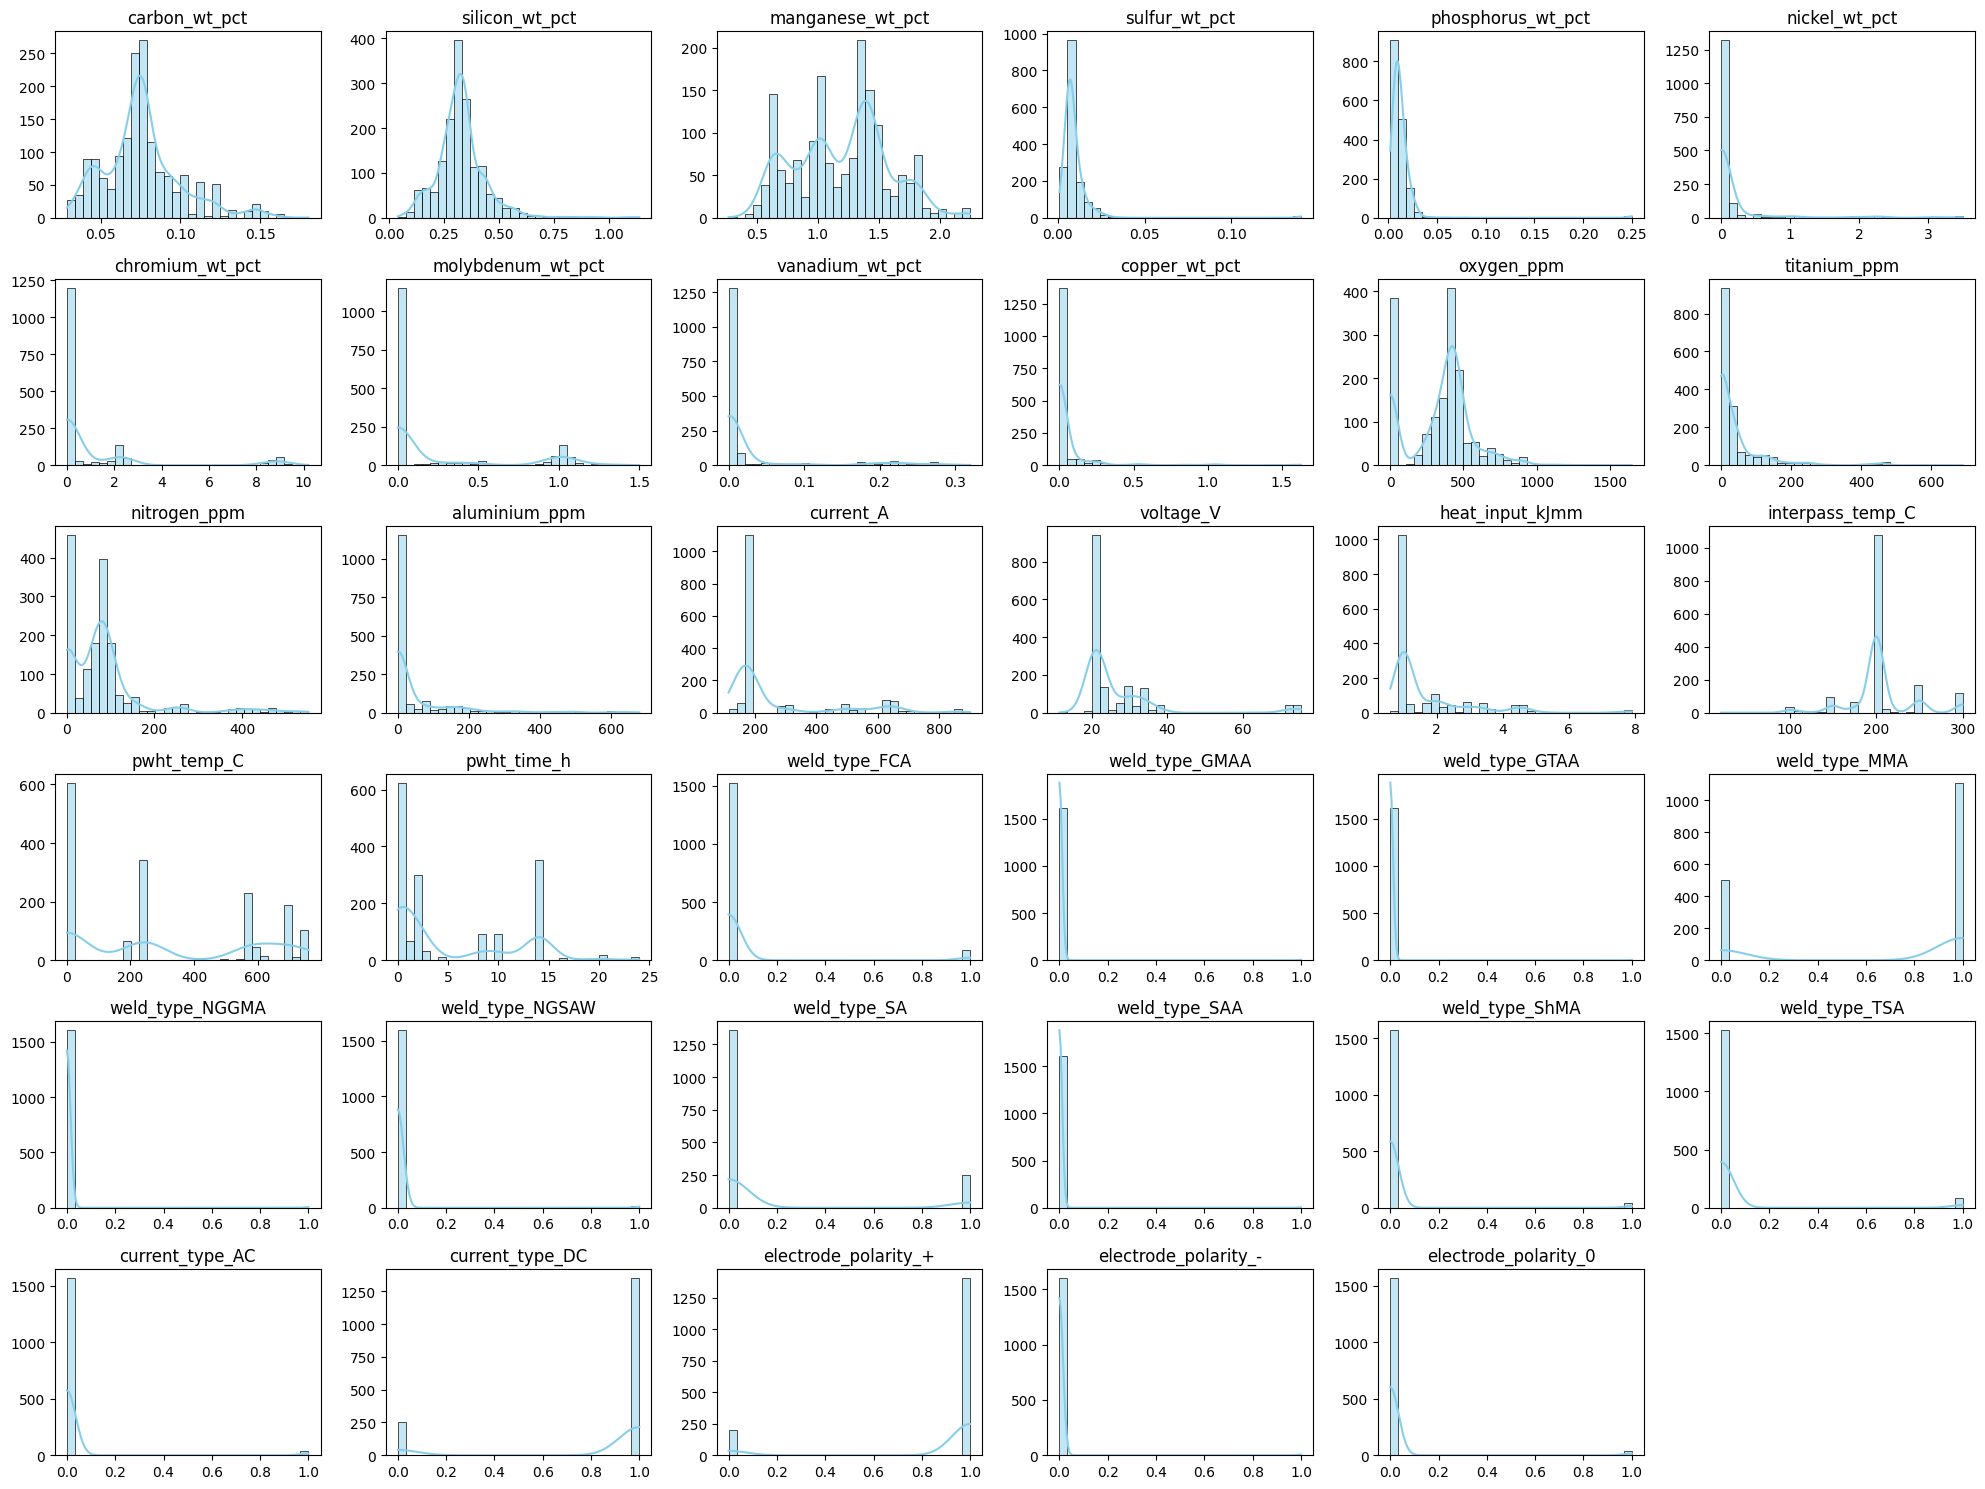

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot
plt.figure(figsize=(20, 15))
for i, col in enumerate(X_train_clean.columns, 1):
    plt.subplot(6, 6, i)
    sns.histplot(X_train_clean[col], bins=30, kde=True, color='skyblue')
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()


### Correlation Analysis

#### Correlation heatmap in features

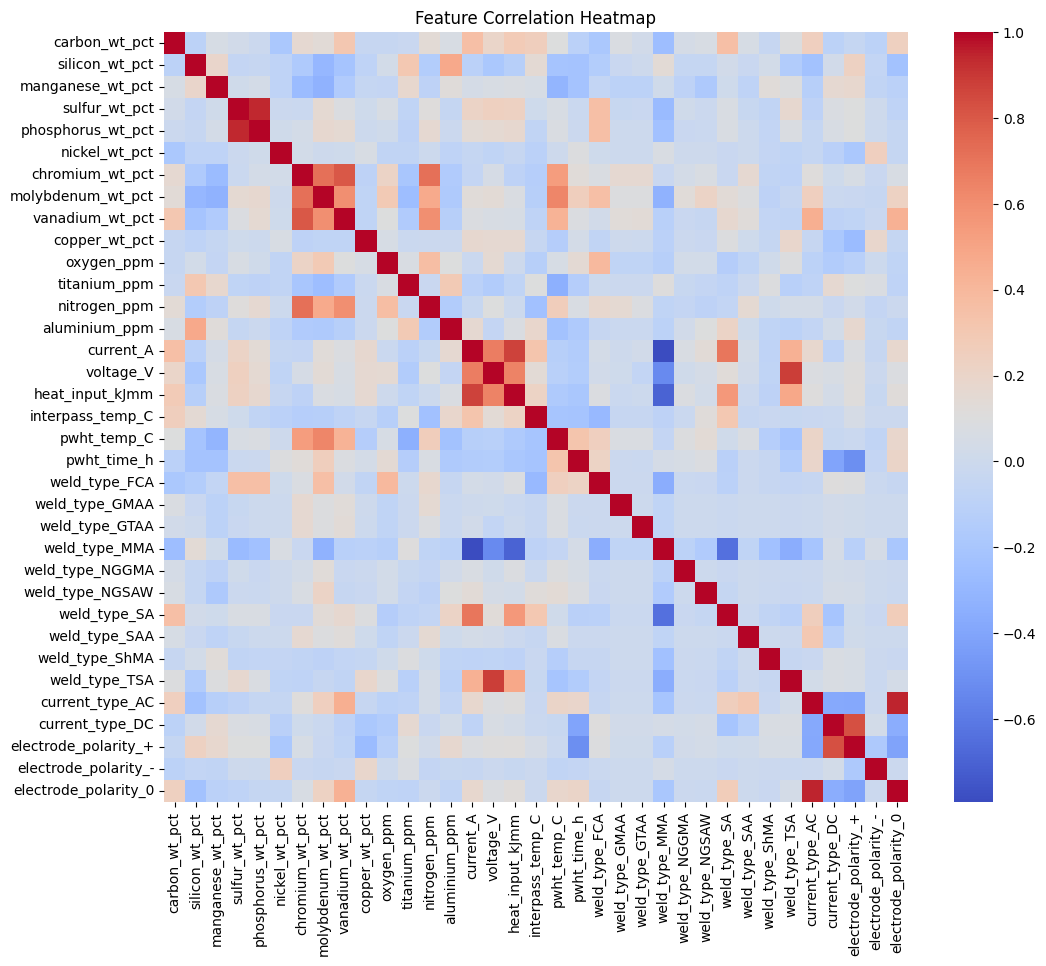

In [78]:
plt.figure(figsize=(12,10))
sns.heatmap(X_train_clean.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


**Highly correlated features**

In [79]:
# Compute absolute correlation matrix
corr_matrix = X_train_clean.corr().abs()

# Select upper triangle (ignore duplicates and self-correlation)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set threshold for “high correlation”
threshold = 0.85

# Find pairs above the threshold
high_corr_pairs = [(col1, col2, upper.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.index
                   if pd.notnull(upper.loc[col1, col2]) and upper.loc[col1, col2] > threshold]

# Convert to DataFrame for readability
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False)

print(f"Highly correlated feature pairs (corr > {threshold}):\n")
print(high_corr_df)

Highly correlated feature pairs (corr > 0.85):

         Feature 1             Feature 2  Correlation
3  current_type_AC  electrode_polarity_0     0.949980
0    sulfur_wt_pct     phosphorus_wt_pct     0.941586
2        voltage_V         weld_type_TSA     0.885016
1        current_A       heat_input_kJmm     0.873908


In [80]:
to_drop = ["electrode_polarity_0", "phosphorus_wt_pct", "weld_type_TSA", "heat_input_kJmm"]

In [81]:
# Drop from training, validation, and test sets
X_train_clean = X_train_clean.drop(columns=to_drop)
X_val_clean = X_val_clean.drop(columns=to_drop)
X_test_clean = X_test_clean.drop(columns=to_drop)

# Print shapes to verify
print(f"X_train shape after dropping: {X_train_clean.shape}")
print(f"X_val shape after dropping:   {X_val_clean.shape}")
print(f"X_test shape after dropping:  {X_test_clean.shape}")

X_train shape after dropping: (1611, 31)
X_val shape after dropping:   (20, 31)
X_test shape after dropping:  (21, 31)


#### Correlation heatmap in target

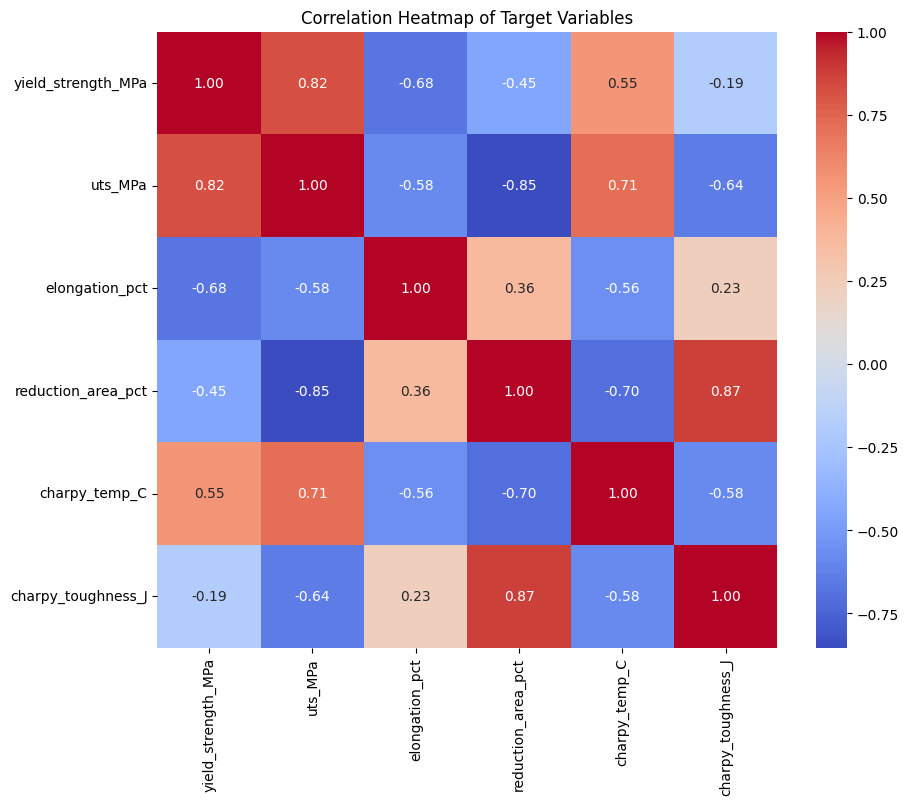

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_train_labeled contains your labeled targets
plt.figure(figsize=(10, 8))
sns.heatmap(y_train_labeled.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Target Variables")
plt.show()


**Highly correlated targets**

In [84]:
corr_matrix = y_train_labeled.corr().abs()

# Upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Threshold for high correlation
threshold = 0.80

high_corr_pairs = [(col1, col2, upper.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.index
                   if pd.notnull(upper.loc[col1, col2]) and upper.loc[col1, col2] > threshold]

high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Target 1", "Target 2", "Correlation"])
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False)

print(f"Highly correlated target pairs (corr > {threshold}):\n")
print(high_corr_df)


Highly correlated target pairs (corr > 0.8):

             Target 1            Target 2  Correlation
2  reduction_area_pct  charpy_toughness_J     0.873245
1             uts_MPa  reduction_area_pct     0.852644
0  yield_strength_MPa             uts_MPa     0.823148


In [85]:
targets_tp_drop = ["charpy_toughness_J", "reduction_area_pct", "uts_MPa"]

In [86]:
# Drop from all target datasets
y_train_labeled = y_train_labeled.drop(columns=targets_tp_drop)
y_val = y_val.drop(columns=targets_tp_drop)
y_test = y_test.drop(columns=targets_tp_drop)

# Print shapes to verify
print(f"y_train_labeled shape after dropping: {y_train_labeled.shape}")
print(f"y_val shape after dropping:             {y_val.shape}")
print(f"y_test shape after dropping:            {y_test.shape}")

y_train_labeled shape after dropping: (93, 3)
y_val shape after dropping:             (20, 3)
y_test shape after dropping:            (21, 3)


### Saving clean datasets

In [ ]:
import os

save_dir = "../../data/clean_data_splits"
os.makedirs(save_dir, exist_ok=True)

# Save feature datasets
X_train_clean.to_csv(os.path.join(save_dir, "X_train.csv"), index=False)
X_val_clean.to_csv(os.path.join(save_dir, "X_val.csv"), index=False)
X_test_clean.to_csv(os.path.join(save_dir, "X_test.csv"), index=False)

# Prepare full training targets for SSL

# y_train_labeled: labeled targets (93 samples)
# X_train_clean: full training features (1611 samples)

# Create unlabeled target DataFrame with -1
y_unlabeled = pd.DataFrame(
    -1, 
    index=X_train_clean.index.difference(y_train_labeled.index),
    columns=y_train_labeled.columns
)

# Combine labeled + unlabeled targets
y_train_full = pd.concat([y_train_labeled, y_unlabeled]).sort_index()

# Save target datasets
y_train_full.to_csv(os.path.join(save_dir, "y_train.csv"), index=False)
y_val.to_csv(os.path.join(save_dir, "y_val.csv"), index=False)
y_test.to_csv(os.path.join(save_dir, "y_test.csv"), index=False)

print(f"All datasets saved successfully in '{save_dir}' directory.")
print(f"X_train: {X_train_clean.shape}, y_train: {y_train_full.shape}")
print(f"X_val:   {X_val_clean.shape}, y_val: {y_val.shape}")
print(f"X_test:  {X_test_clean.shape}, y_test: {y_test.shape}")


All datasets saved successfully in '../../clean_data_splits' directory.
X_train: (1611, 31), y_train: (1611, 3)
X_val:   (20, 31), y_val: (20, 3)
X_test:  (21, 31), y_test: (21, 3)
